# Wisconsin Breast Cancer (Diagnostic) - Full Classification Workflow

The goal is to determine whether a patient has benign or malignant cancer.

Attribute Information:

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter)
b) texture (standard deviation of gray-scale values)
c) perimeter
d) area
e) smoothness (local variation in radius lengths)
f) compactness (perimeter^2 / area - 1.0)
g) concavity (severity of concave portions of the contour)
h) concave points (number of concave portions of the contour)
i) symmetry
j) fractal dimension ("coastline approximation" - 1)

Links for the dataset:
- Kaggle: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data
- UCI ML: https://archive-beta.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic



In [33]:
# import data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# import feature selection libraries
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE, RFECV

# import scipy stats
import scipy.stats as stats

### Read and Analyze the dataset

Before doing any preprocessing, such as feature scaling or features selection, we start with basic data analysis. We look at the data's shape, the features that are available, and the target variable.

In [2]:
# import cancer data
cancer = pd.read_csv('datasets/cancer.csv')

# check data
cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [3]:
# get column names
cancer.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [4]:
# check data info
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

From reading and seeing a sample of the data above, we can observe several things:
- There are two columns which do not contribute to either the features or the target: 'id' and 'Unnamed: 32'. We can exclude these from our X and y.
- The column 'diagnosis' will be our target variable. It is in the form of an object with values M for malignant and B for benign.
- The feature names seem to be referencing physical features for a tumor. There are 10 physical features, but for each 3 different values are recorded: the mean, standard error (se), and worst. These values may be correlated to each other, hence we may not need to use all 30 features for classification.

In [5]:
# check data description
cancer.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


From a brief glimpse into the values in each features, we can see that there is a considerable difference in value between one feature and another. Therefore, for some types of classifiers, we may need to use feature scaling to make sure the values are within the same range.

In [6]:
# check for null values
cancer.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

There are no missing values in all relevant features, hence no need to fill in missing values. We end this first process by splitting the data into features and target dataframes X and y.

In [7]:
# separate data into features and labels, drop id, diagnosis, and Unnamed: 32 columns for X
X = cancer.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1)

# separate data into features and labels, diagnosis column for y
y = cancer['diagnosis']

# check X
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Benign:  357
Malignant:  212


c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


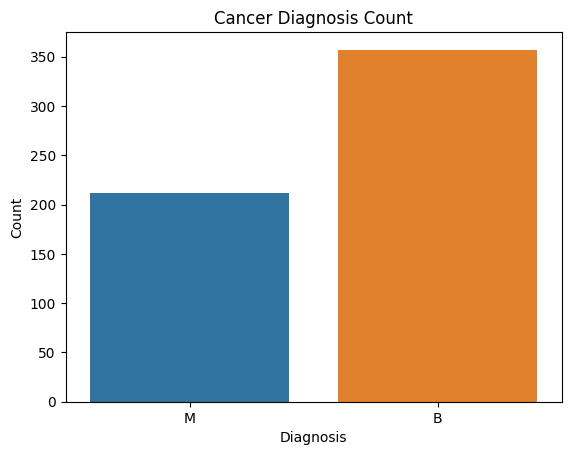

In [8]:
# get y values count into variables
B, M = y.value_counts()

#print benign and malignant counts
print('Benign: ', B)
print('Malignant: ', M)


# visualize y in a countplot
ax = sns.countplot(y)
ax.set_title('Cancer Diagnosis Count')
ax.set_xlabel('Diagnosis')
ax.set_ylabel('Count')
plt.show()

### Visualize the data

We can try to visualize each feature in the data to get an idea of which features are similar, which features clearly separate between benign and malignant and vice verse, hence will give us an idea of which features we can safely eliminate during feature selection. We don't select the features here, we just get a basic intuition of what the features look like.

Before we visualize the features, we need to standardize them beforehand because of the differences between the values.

#### Violin Plot

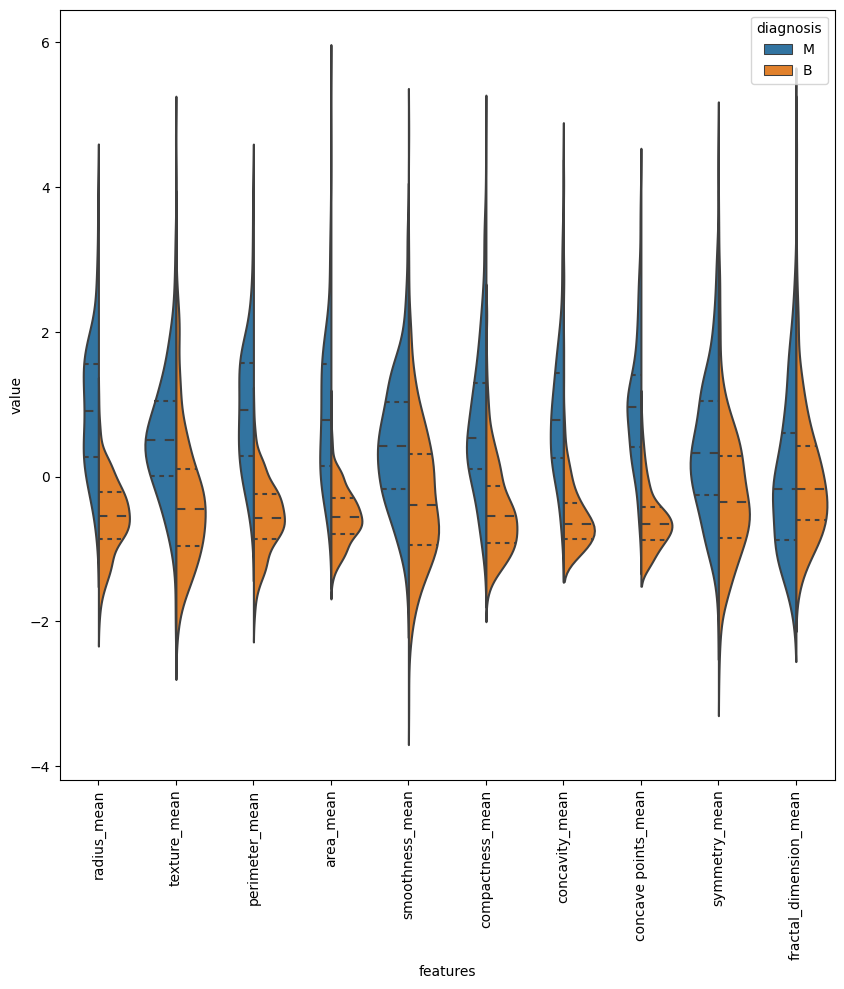

In [9]:
# standardize data while keeping the pandas dataframe
y_vis = y
x_vis = X

# standardize data
X_std = (x_vis - x_vis.mean()) / x_vis.std()

# visualize first 10 features in a violinplot
data_vis = pd.concat([y_vis, X_std.iloc[:,0:10]], axis=1)
data_vis = pd.melt(data_vis, id_vars="diagnosis", var_name="features", value_name='value')

plt.figure(figsize=(10,10))
ax = sns.violinplot(x="features", y="value", hue="diagnosis", data=data_vis, split=True, inner="quart")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

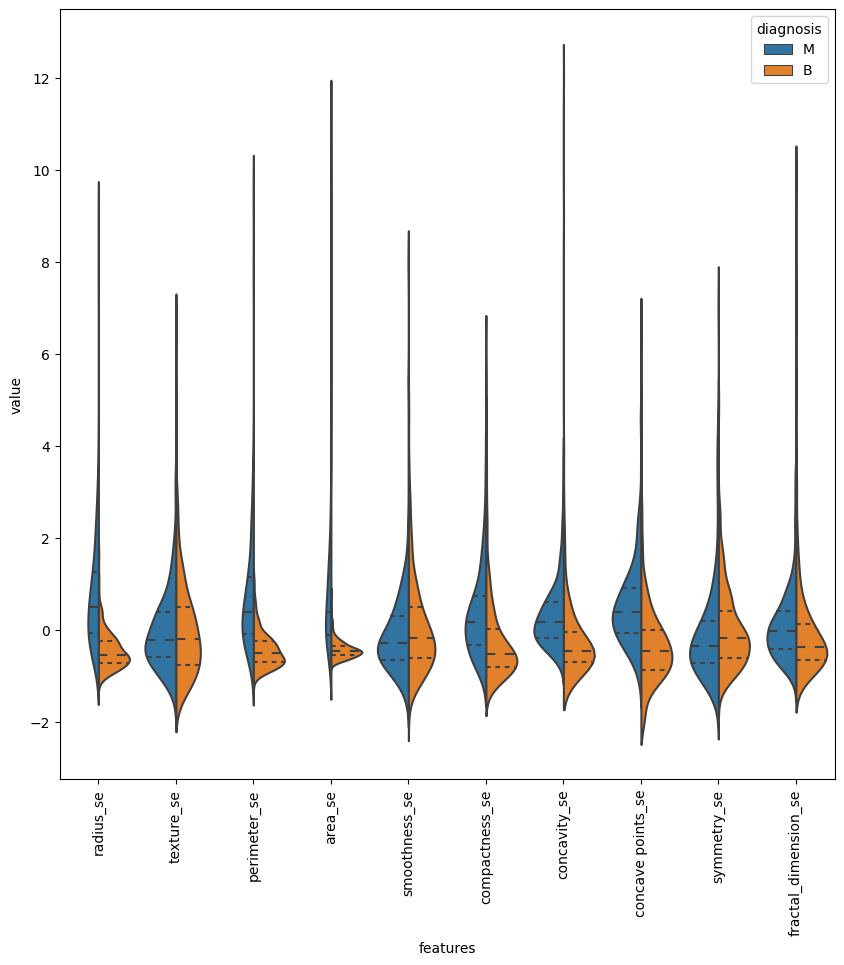

In [10]:
# visualize the next 10 features in a violinplot
data_vis = pd.concat([y_vis, X_std.iloc[:,10:20]], axis=1)
data_vis = pd.melt(data_vis, id_vars="diagnosis", var_name="features", value_name='value')

plt.figure(figsize=(10,10))
ax = sns.violinplot(x="features", y="value", hue="diagnosis", data=data_vis, split=True, inner="quart")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

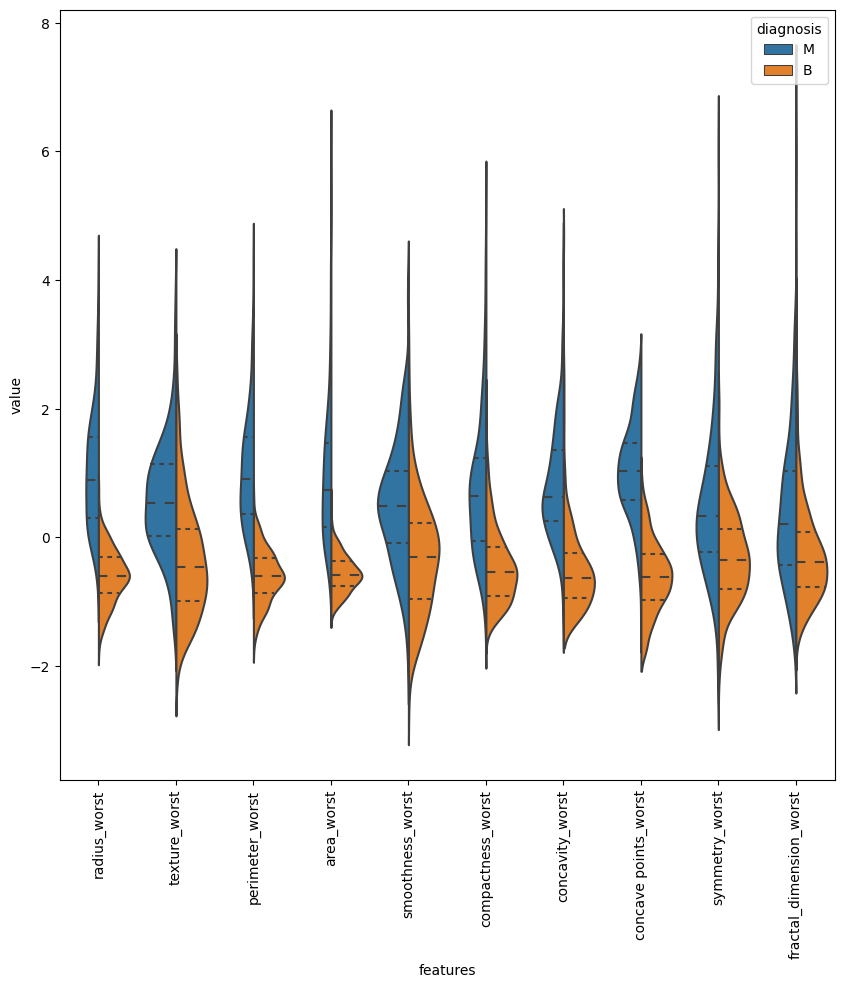

In [11]:
# visualize the next 10 features in a violinplot
data_vis = pd.concat([y_vis, X_std.iloc[:,20:30]], axis=1)
data_vis = pd.melt(data_vis, id_vars="diagnosis", var_name="features", value_name='value')

plt.figure(figsize=(10,10))
ax = sns.violinplot(x="features", y="value", hue="diagnosis", data=data_vis, split=True, inner="quart")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()


#### Box Plot

An alternative to the violin plot is the box plot. They are useful to see the location of outliers in each feature set.

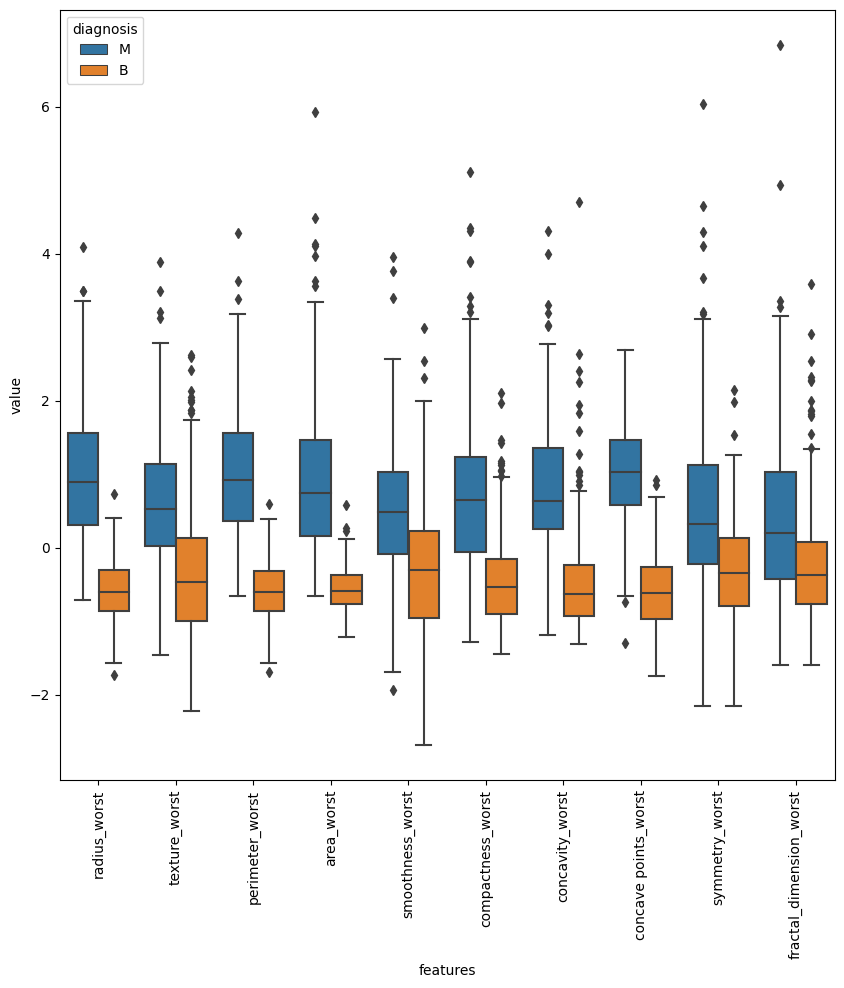

In [12]:
# create a box plot for the first 10 features
plt.figure(figsize=(10,10))
ax = sns.boxplot(x = 'features', y='value', hue='diagnosis', data=data_vis)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()


From the above plots, we can see that several of the features seem to have very similar spread in data, which indicates they may be correlated to each other. For example:
- radius_mean, perimiter_mean, area_mean seem to have similar shapes, this holds true for their se & worst counterparts
- concavity and concave points seem to be similar
- symmetry_worst and fractal_dimension_worst are also very similar

In order for us to more clearly compare between two or more features, we can visualize them in more detail using a jointplot.

#### Joint Plot correlation

c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


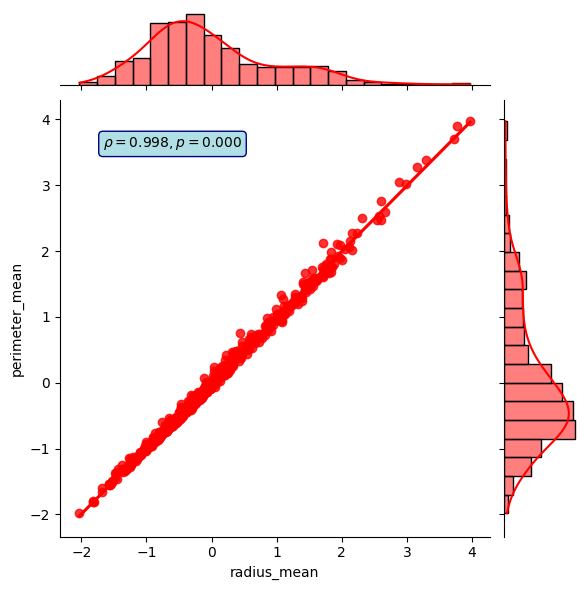

In [13]:
# plot between radius_mean and perimeter_mean using jointplot
j_plot = sns.jointplot(X_std.loc[:,'radius_mean'], X_std.loc[:,'perimeter_mean'], kind='reg', color='r')

r, p = stats.pearsonr(X_std.loc[:,'radius_mean'], X_std.loc[:,'perimeter_mean'])

# annotate the plot with the pearson correlation coefficient and p-value
j_plot.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
plt.show()

c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


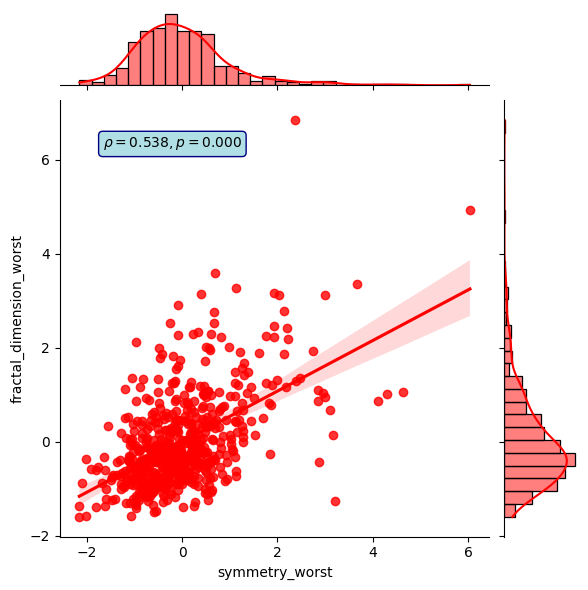

In [14]:
# plot between symmetry_worst and fractal_dimension_worst using jointplot
j_plot = sns.jointplot(X_std.loc[:,'symmetry_worst'], X_std.loc[:,'fractal_dimension_worst'], kind='reg', color='r')

r, p = stats.pearsonr(X_std.loc[:,'symmetry_worst'], X_std.loc[:,'fractal_dimension_worst'])

# annotate the plot with the pearson correlation coefficient and p-value
j_plot.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})

plt.show()

As can be seen from the above plots, radius_mean and perimeter mean are very correlated, while our previous observation of symmetry_worst and fractal_dimension_worst seem to be less correlated than we thought. In order to see between all pairs of features, we can visualize using a heatmap.

#### Correlation Heatmap

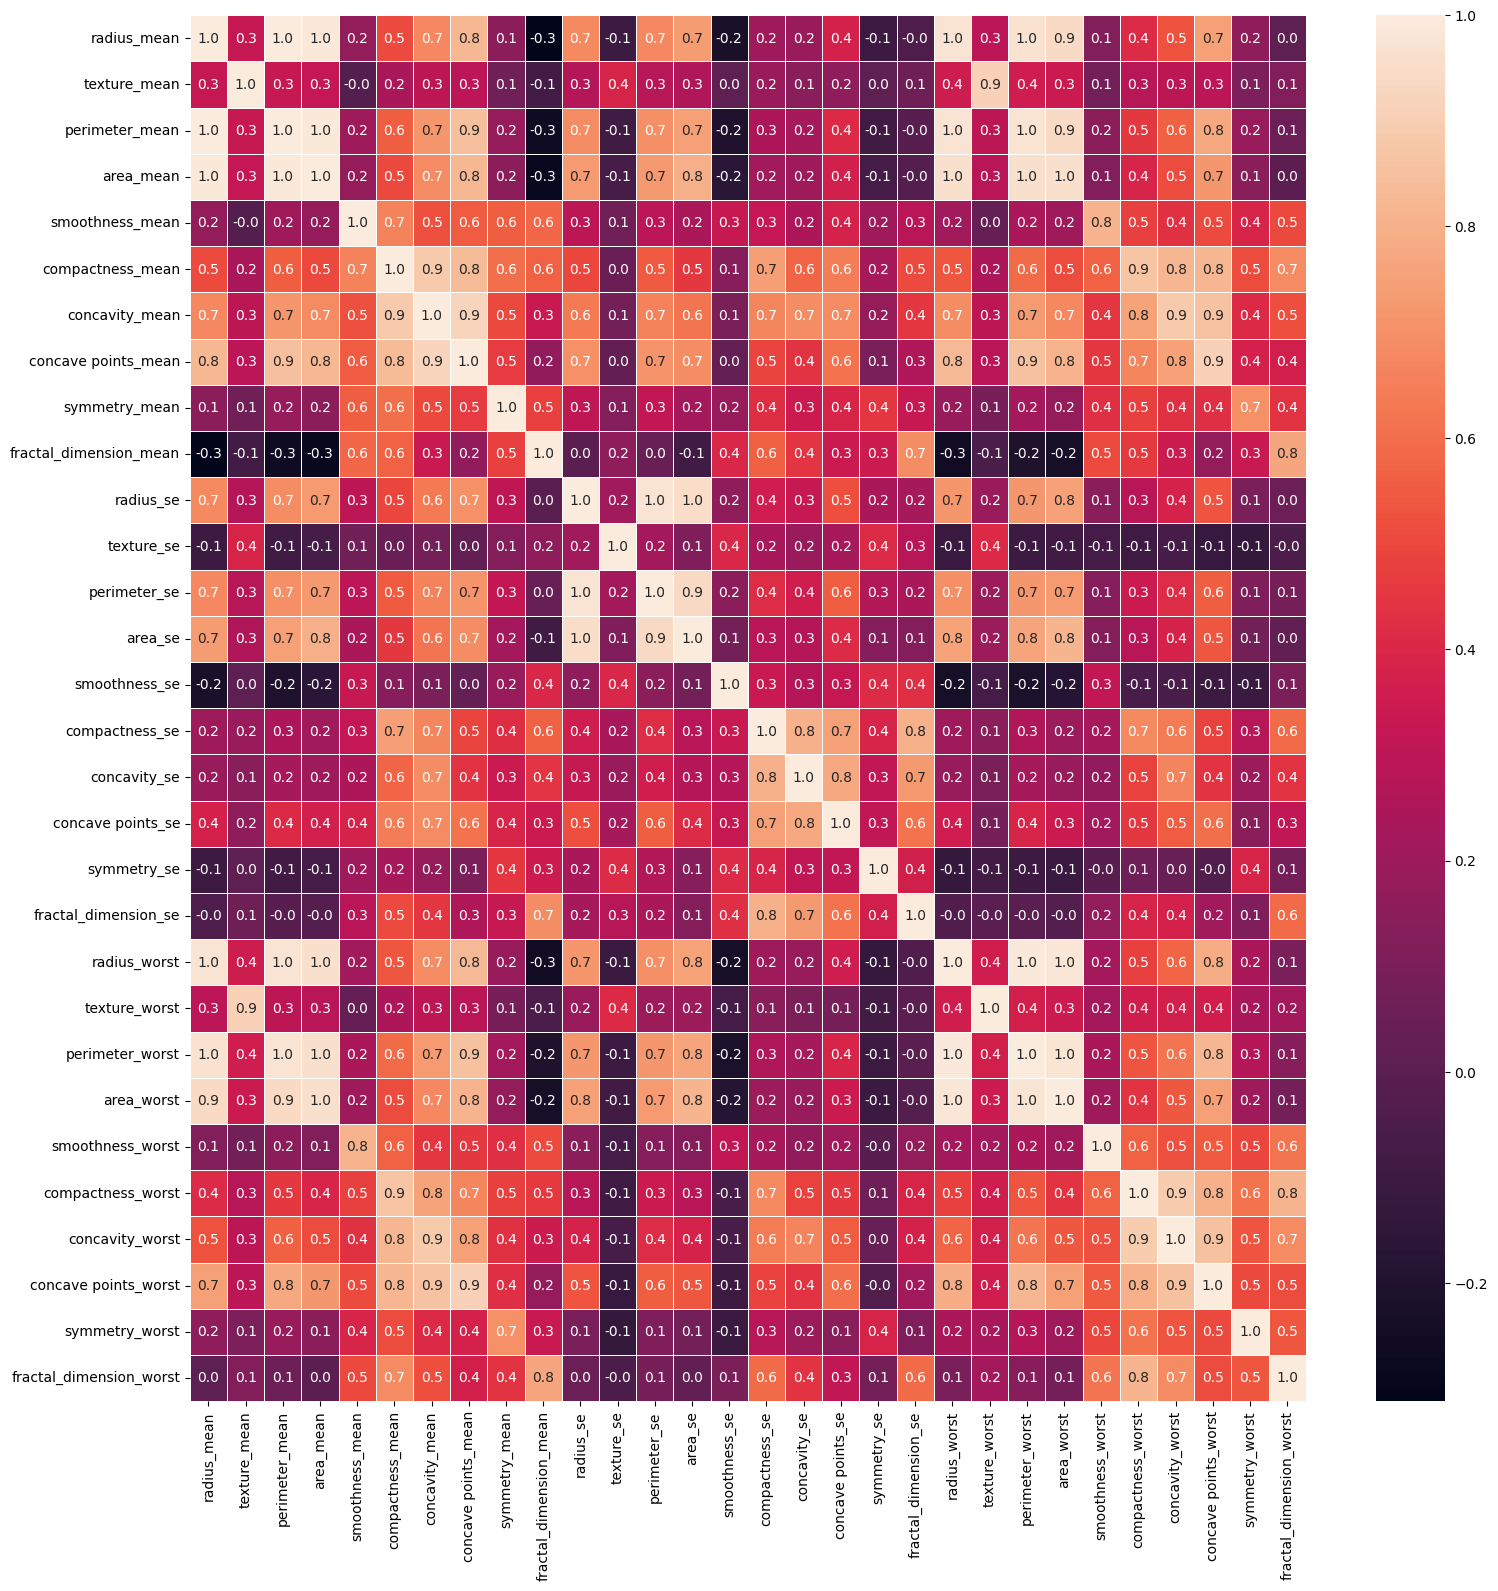

In [15]:
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X_std.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

plt.show()

#### Swarm Plot

Besides the above visualizations, for a relatively low number of data, we can use a swarm plot to visualize the spread of labels in a particular features. This will help us determine whether a feature by itself is a good predictor of our target labels or not.

c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


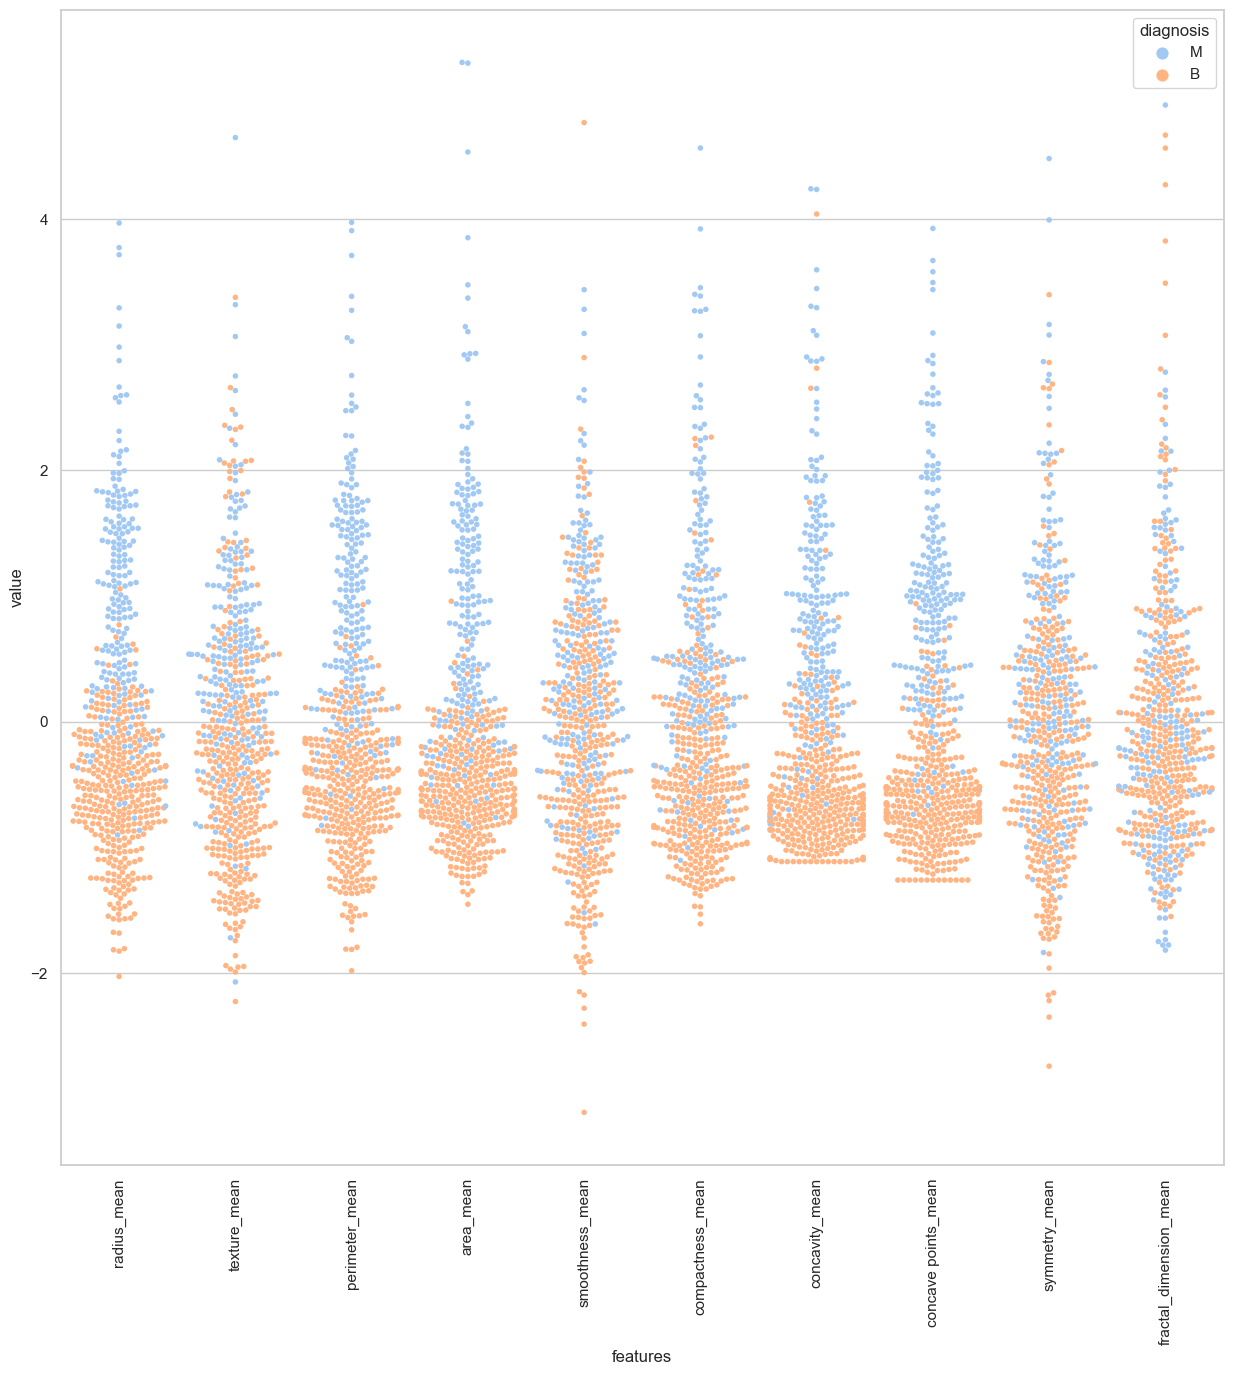

In [16]:
sns.set(palette='pastel', style='whitegrid')

# create a swarm plot for the first 10 features in X_std
data_vis = pd.concat([y_vis, X_std.iloc[:,0:10]], axis=1)
data_vis = pd.melt(data_vis, id_vars="diagnosis", var_name="features", value_name='value')

plt.figure(figsize=(15,15))
ax = sns.swarmplot(x="features", y="value", hue="diagnosis", data=data_vis, size=4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 28.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 14.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 29.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 43.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packa

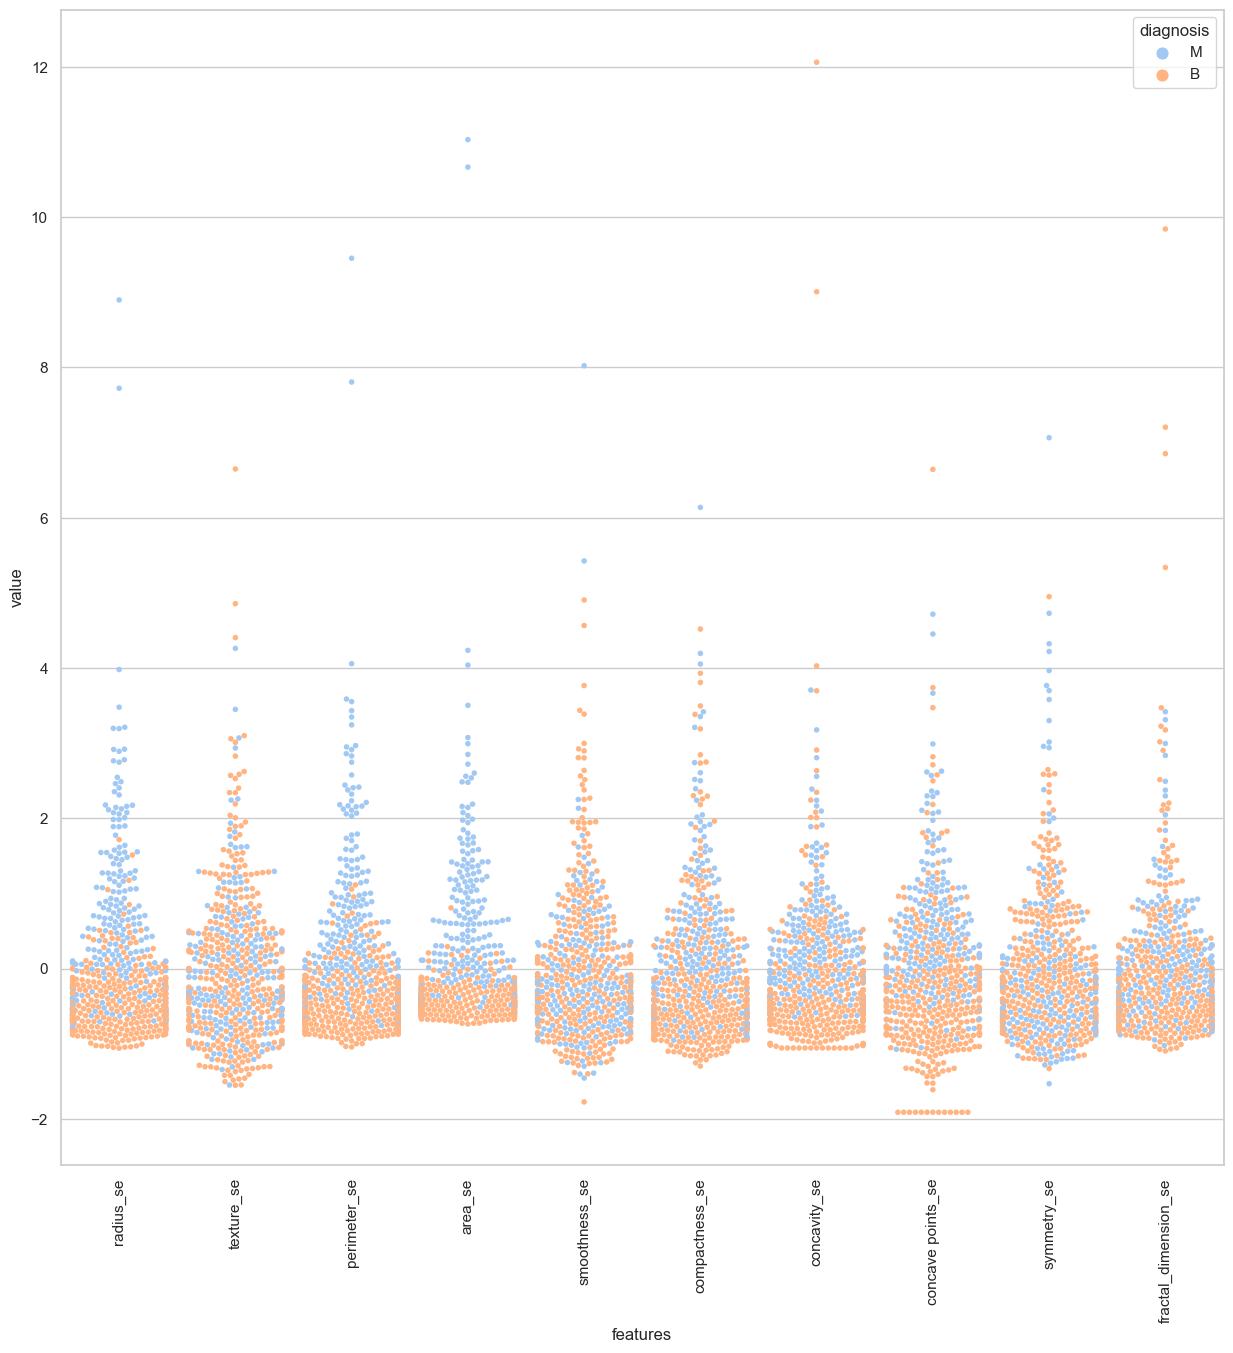

In [17]:
# create swarm plot for the next 10 features in X_std
data_vis = pd.concat([y_vis, X_std.iloc[:,10:20]], axis=1)
data_vis = pd.melt(data_vis, id_vars="diagnosis", var_name="features", value_name='value')

plt.figure(figsize=(15,15))
ax = sns.swarmplot(x="features", y="value", hue="diagnosis", data=data_vis, size=4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 7.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 15.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


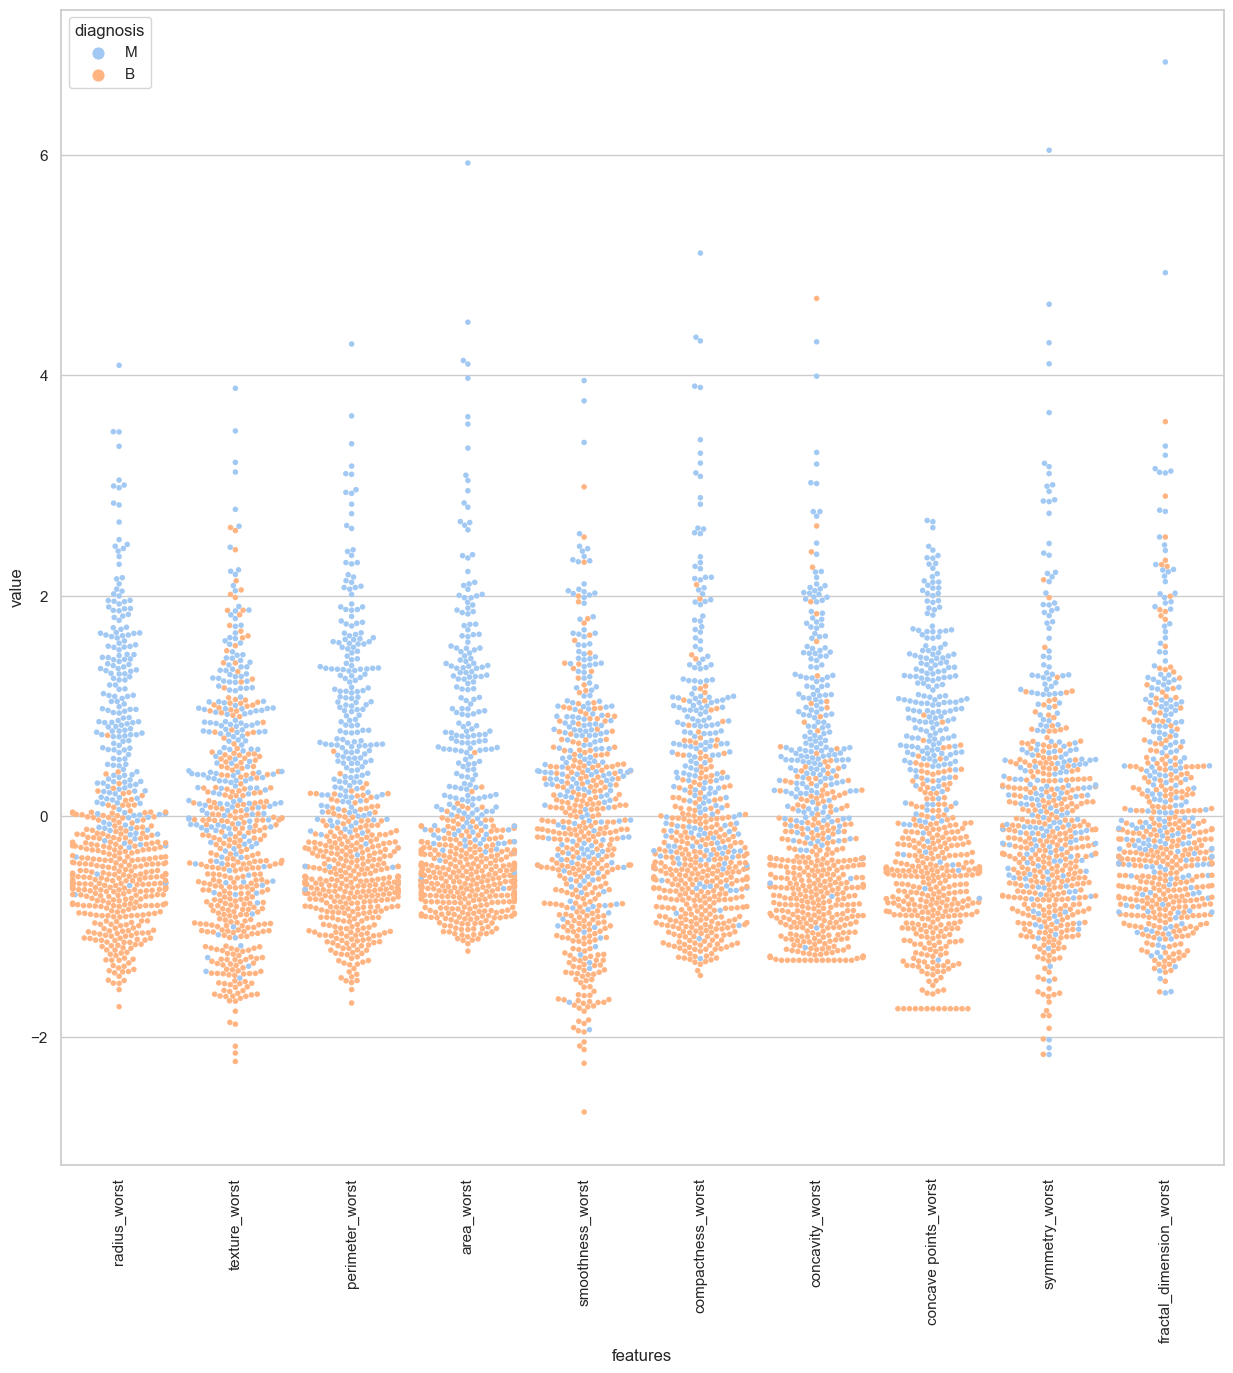

In [18]:
# create swarm plot for the next 10 features in X_std
data_vis = pd.concat([y_vis, X_std.iloc[:,20:30]], axis=1)
data_vis = pd.melt(data_vis, id_vars="diagnosis", var_name="features", value_name='value')

plt.figure(figsize=(15,15))
ax = sns.swarmplot(x="features", y="value", hue="diagnosis", data=data_vis, size=4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

As we can see from the swarm plot, some features separate the target labels very cleary, while others do not. For example:
- There is clear distinction between benign & malignant in radius, perimeter, area, concavity, concave points
- There is no clear distinction between benign & malignant in symmetry, smoothness, fractal_dimension

This can help guide use during feature selection or feature engineering.

### Feature Selection

#### Feature selection with correlation

Using the heatmap we created above, we can identify groups of features which are correlated to each other. Then, we select 1 of the features from the group to be in the final feature set. To select the one representative, we can do it randomly or we can observe how well that feature splits the labels in the swarm plot. For this list of features, the groups of correlated features are below (bolded features are the selected ones for the final feature set)

- radius_mean, perimeter_mean, **area_mean**, radius_worst, perimiter_worst, area_worst
- **texture_mean**, texture_worst
- **smoothness_mean**, smoothness_worst
- compactness_mean, **concavity_mean**, concave points_mean, compactness_worst, concavity_worst, concave points_worst
- **symmetry_mean**
- **fractal_dimension_mean**
- radius_se, perimeter_se, **area_se**
- **texture_se**
- **smoothness_se**
- compactness_se, **concavity_se**, concave points_se
- **symmetry_se**
- **fractal_dimension_se**
- **symmetry_worst**
- **fractal_dimension_worst**

The final list of features has 14 features.

In [19]:
# list all the features in X_std
X_std.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [20]:
drop_list_corr = ['radius_mean', 'perimeter_mean',
       'compactness_mean', 
       'concave points_mean', 
       'radius_se', 'perimeter_se', 
       'compactness_se', 'concave points_se',
       'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst']

# drop the features with high correlation
X_std_corr = X_std.drop(drop_list_corr, axis=1)
X_std_corr.columns


Index(['texture_mean', 'area_mean', 'smoothness_mean', 'concavity_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'area_se',
       'smoothness_se', 'concavity_se', 'symmetry_se', 'fractal_dimension_se',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

We can check for correlation in the final feature set using the heatmap again.

<AxesSubplot:>

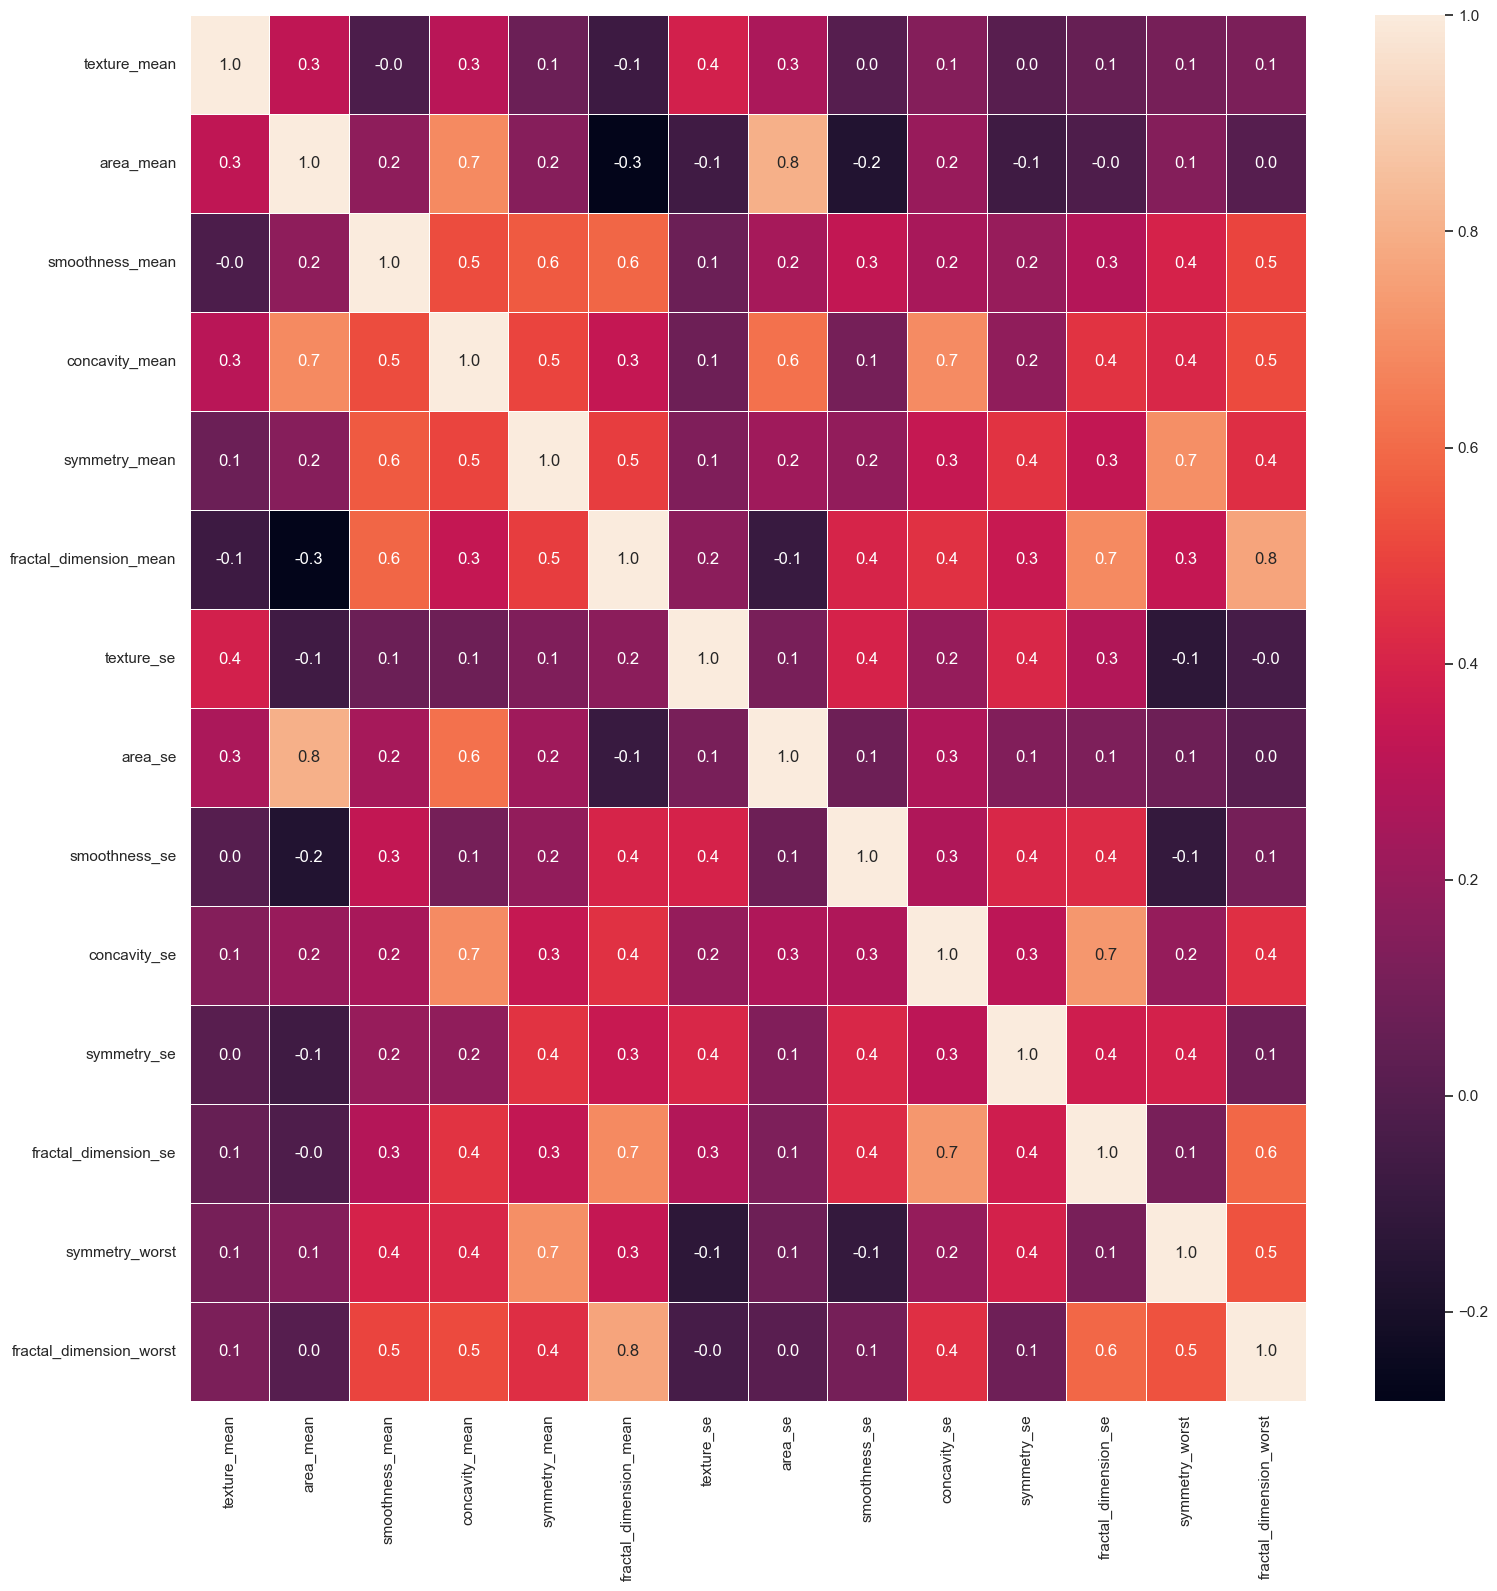

In [21]:
# create correlation matrix for the features in X_std_corr
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X_std_corr.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)


##### Logistic regression on subset of features

In [23]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_std_corr, y, test_size=0.2, random_state=42)

# create a logistic regression model
log_reg = LogisticRegression()

# fit the model with the training data
log_reg.fit(X_train, y_train)

# predict on the test set
y_pred = log_reg.predict(X_test)

# print the accuracy score
print('Accuracy score: ', accuracy_score(y_test, y_pred))

# print the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))


Accuracy score:  0.956140350877193
Confusion matrix:  [[68  3]
 [ 2 41]]


##### Logistic Regression on full dataset

In [24]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

# create a logistic regression model
log_reg = LogisticRegression()

# fit the model with the training data
log_reg.fit(X_train, y_train)

# predict on the test set
y_pred = log_reg.predict(X_test)

# print the accuracy score
print('Accuracy score: ', accuracy_score(y_test, y_pred))

# print the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))


Accuracy score:  0.9736842105263158
Confusion matrix:  [[70  1]
 [ 2 41]]


As you can see, we reached accuracy of 95% with only a fraction of the feature set. With this amount of data, in terms of training time, it did not matter much if we reduced the feature set since the dataset is very small. Some advantages of using less features:

- Reduce overfitting: fewer features help reduce overfitting. More features may be good during training, but may not generalize well otherwise.
- Improve training time: more features, more calculations. Feature selection will help reduce training time when the data set is large.
- Improve interpretability: with less features, we can get a sense of how our machine learning model is working, and how it is making predictions. This can be very useful if the features are related to something we can influence/change in the real world, both in software and in physical objects.
- Reduce the risk of human bias: Some features that are collected may be irrelant or are biased features. Such features can negatively impact the performance of the model, instead of improving it.


Besides using a subset of features, the next thing we can do is try other machine learning models on the same dataset.


##### Random forest classifier on subset of features

In [25]:
# create a random forest classifier for the features in X_std_corr
rfc = RandomForestClassifier()

# create training and test sets for the features in X_std_corr
X_train, X_test, y_train, y_test = train_test_split(X_std_corr, y, test_size=0.2, random_state=42)

# fit the model with the training data
rfc.fit(X_train, y_train)

# predict on the test set
y_pred = rfc.predict(X_test)

# print the accuracy score
print('Accuracy score: ', accuracy_score(y_test, y_pred))

# print the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))


Accuracy score:  0.9736842105263158
Confusion matrix:  [[70  1]
 [ 2 41]]


##### Random forest classifier on full set of features

In [26]:
# create a random forest classifier for the features in X_std
rfc = RandomForestClassifier()

# create training and test sets for the features in X_std
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

# fit the model with the training data
rfc.fit(X_train, y_train)

# predict on the test set
y_pred = rfc.predict(X_test)

# print the accuracy score
print('Accuracy score: ', accuracy_score(y_test, y_pred))

# print the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))


Accuracy score:  0.9649122807017544
Confusion matrix:  [[70  1]
 [ 3 40]]


In the above example, the subset of features actually perfomed better than the full set of features. This may be caused by irrelevant or biased features which may reduce the model's performance, hence having a subset of the most relevant features actually improved the performance.

#### Feature selection using univariate feature selection

With this selection, we calculate how much each feature contributes to the difference in the target label. That is, how much of the change in each independent variable (feature) contributes to the change in dependent variable (target). We then rank each feature and take several of the features that are most relevant. This is done by calculating a univariate statistical test between the feature and target, such as the ANOVA F-score or chi-squared. In sklearn, we can do this by using the function SelectKBest.

In [27]:
X_std.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [30]:
# create training and test sets for the features from X_std
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

# select feature using SelectKBest
skb = SelectKBest(score_func=f_classif, k=10).fit(X_train, y_train)

# print the scores for the features
print('Scores for the features: ', skb.scores_)

# print the features with the highest scores
print('Features with the highest scores: ', X_train.columns[skb.get_support()])

# transform the data to include only the features with the highest scores
X_train_skb = skb.transform(X_train)
X_test_skb = skb.transform(X_test)


Scores for the features:  [4.82233945e+02 9.49177878e+01 5.22489267e+02 4.23654133e+02
 7.41901474e+01 2.42589647e+02 3.96662370e+02 6.95179785e+02
 6.24695416e+01 9.27563953e-02 1.86591816e+02 4.71364906e-03
 1.76223231e+02 1.65307401e+02 1.53557408e+00 3.13387910e+01
 2.21796131e+01 7.65659230e+01 1.01038152e-02 7.90103995e-01
 6.45350668e+02 1.26681903e+02 6.81263759e+02 4.95787667e+02
 1.02973429e+02 2.40492785e+02 3.31330906e+02 7.46492117e+02
 1.08953927e+02 4.91979224e+01]
Features with the highest scores:  Index(['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean',
       'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst',
       'concavity_worst', 'concave points_worst'],
      dtype='object')


##### Logistic Regression with univariate feature selection

In [31]:
# create a logistic regression model
log_reg = LogisticRegression()

# fit the model with the training data
log_reg.fit(X_train_skb, y_train)

# predict on the test set
y_pred = log_reg.predict(X_test_skb)

# print the accuracy score
print('Accuracy score: ', accuracy_score(y_test, y_pred))

# print the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))



Accuracy score:  0.9736842105263158
Confusion matrix:  [[69  2]
 [ 1 42]]


##### Random Forest with univariate feature selection

In [32]:
# create a random forest classifier
rfc = RandomForestClassifier()

# fit the model with the training data
rfc.fit(X_train_skb, y_train)

# predict on the test set
y_pred = rfc.predict(X_test_skb)

# print the accuracy score
print('Accuracy score: ', accuracy_score(y_test, y_pred))

# print the confusion matrix
print('Confusion matrix: ', confusion_matrix(y_test, y_pred))


Accuracy score:  0.956140350877193
Confusion matrix:  [[69  2]
 [ 3 40]]


#### Feature selection through Recursive Feature Elimination (RFE)

The most important features are selected based on a recursive algorithm where we consider smaller & smaller sets of features in each loop. A classifier is selected beforehand to be used as the model for calculating the best set of features.

There are two types of RFE in sklearn:
- RFE: normal recursive feature elimination
- RFECV: recursive feature elimination with autotuning of the number of features with cross-validation

##### RFE on Random Forest Classifier

Here, we determine the number of features we want to get as the best features, and the algorithm determines these features.

In [35]:
# create training and test sets for the features from X_std
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

# create a random forest classifier
rfc = RandomForestClassifier()

# run RFE with the random forest classifier
rfe = RFE(estimator=rfc, n_features_to_select=5, step=1)

# fit the model with the training data
rfe.fit(X_train, y_train)

# print the features that are selected
print('Features selected: ', X_train.columns[rfe.support_])

# print accuracy score
print('Accuracy score: ', rfe.score(X_test, y_test))



Features selected:  Index(['concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst',
       'concave points_worst'],
      dtype='object')
Accuracy score:  0.956140350877193


##### RFECV on Random Forest Classifier

Here, the number of features as well as the feature names will be determined for us.

In [36]:
# create training and test sets for the features from X_std
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

# create a random forest classifier
rfc = RandomForestClassifier()

# run RFECV with the random forest classifier
rfecv = RFECV(estimator=rfc, step=1, cv=5, scoring='accuracy')

# fit the model with the training data
rfecv.fit(X_train, y_train)

# print the features that are selected
print('Features selected: ', X_train.columns[rfecv.support_])
print('Optimal number of features: ', rfecv.n_features_)

# print accuracy score
print('Accuracy score: ', rfecv.score(X_test, y_test))


Features selected:  Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'concavity_mean', 'concave points_mean', 'area_se', 'radius_worst',
       'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst'],
      dtype='object')
Optimal number of features:  16
Accuracy score:  0.956140350877193


c:\Users\IKHSAN-RTX\Envs\deeplearning\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


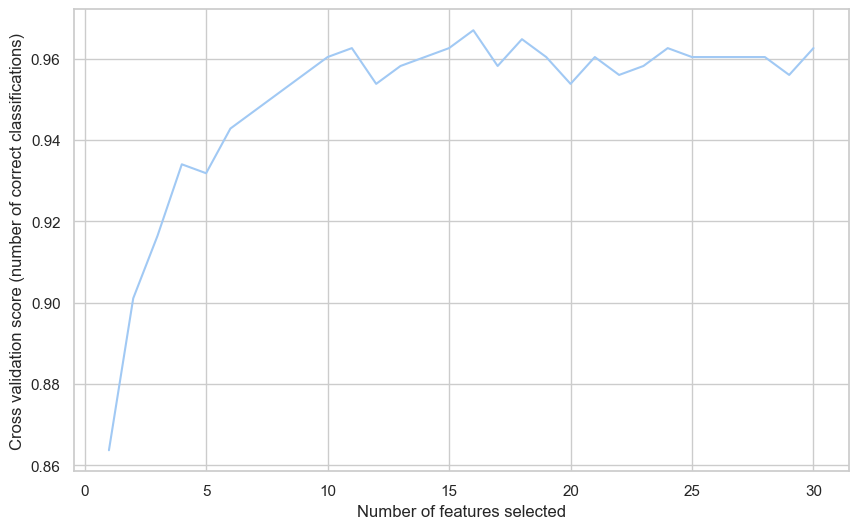

In [38]:
# plot the number of features vs. the cross-validation score
plt.figure(figsize=(10, 6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (number of correct classifications)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()